# Preprocessing

---
## Imports

In [21]:
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

from utils.duplicates import remove_rows, get_duplicates_to_delete, visualize_duplicates
from utils.tensorflow_preprocessing import prepare_image_target_dataset, prepare_image_dataset

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [22]:
df = pd.read_csv('../data/processed/csv/df.csv')
duplicates = pd.read_csv('../data/processed/csv/duplicates.csv')

--- 
## Remove duplicates

### Automatically delete:
- For each duplicate group, delete all but one rows marked as "Duplicate" for each "Style".
- Outputs "df_no_dup".

In [23]:
duplicates_to_delete = get_duplicates_to_delete(duplicates)
df_no_dup = remove_rows(df, duplicates_to_delete)
df_no_dup.head()

Identifying rows to delete...


100%|██████████| 5684/5684 [00:02<00:00, 2528.93it/s]

Removing rows...


,Path,Type,Width,Height,Ratio,Mode,Class,Style
0,tables/Eclectic/4029eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
1,tables/Eclectic/4107eclectic-nightstands-and-b...,jpg,350,350,1.0,RGB,tables,Eclectic
2,tables/Eclectic/3885eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
3,tables/Eclectic/4040eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
4,tables/Eclectic/4171eclectic-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Eclectic


### Manually delete:
- Any rows marked as "Inspect" that belongs in the wrong "Class".
- Overwrite "df", as this DataFrame will continue to be used for further preprocessing.

In [24]:
inspects = duplicates[duplicates['Duplicate_Type'] == 'Inspect']
total_inspect_groups = inspects["Group"].nunique(dropna=False)


In [25]:
# Delete one of each pair
# inspects_rows_to_delete = [91, 154, 205, 227, 235, 277, 280, 281, 287, 290, 299, 310, 318, 323, 325] 

# Only delete very different class ("tables" and "beds"). Similar classes are kept ("chairs" and "sofas")
inspects_rows_to_delete = [91, 205]

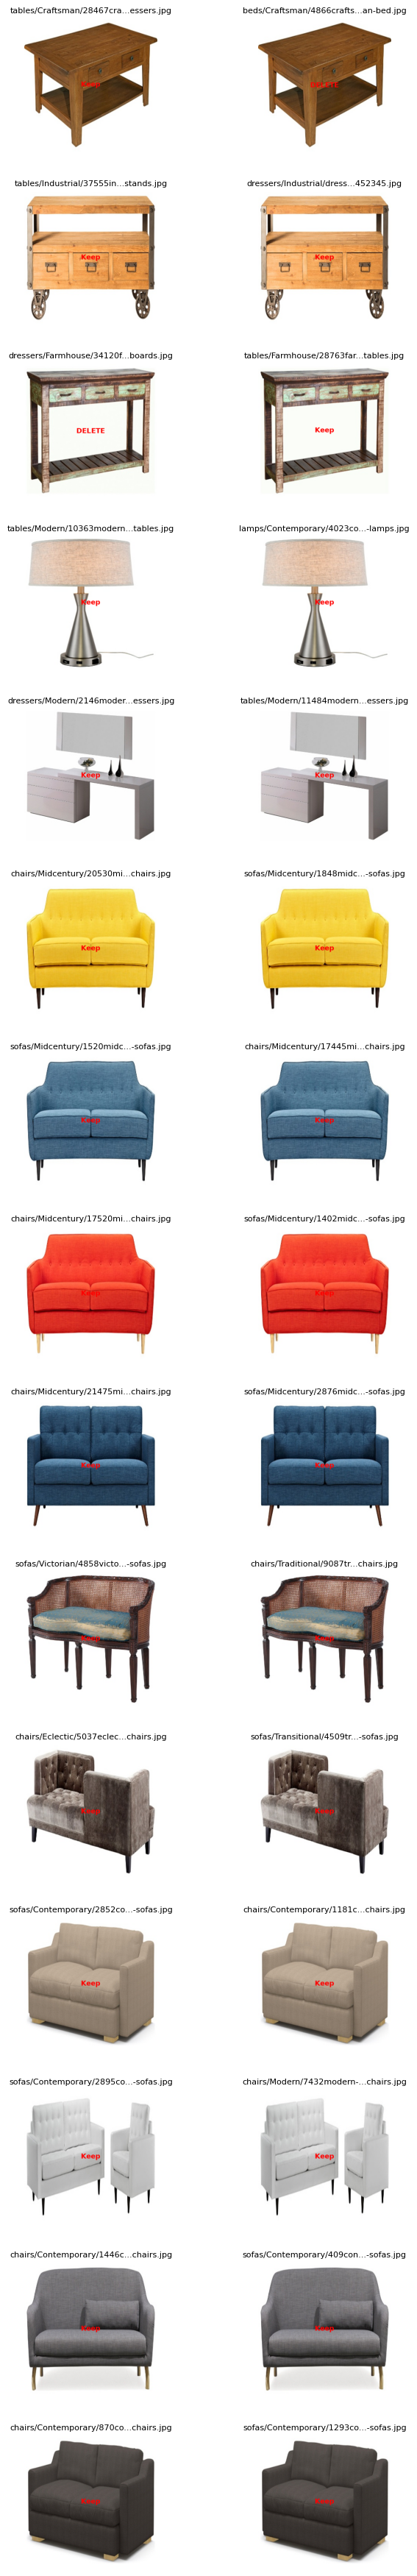

In [26]:
inspect_review = inspects.copy()
inspect_review["Duplicate_Type"] = "Keep"

inspect_review.loc[inspects_rows_to_delete, "Duplicate_Type"] = "DELETE"
visualize_duplicates(inspect_review, total_inspect_groups)

In [27]:
inspects_to_delete = inspect_review[inspect_review["Duplicate_Type"] == "DELETE"]
inspects_to_delete

,Group,Duplicate_Type,Path,Type,Width,Height,Ratio,Mode,Class,Style,Hash
91,41,DELETE,beds/Craftsman/4866craftsman-bed.jpg,jpg,350,350,1.0,RGB,beds,Craftsman,fbea6ebbd105a451cd78b1ccae23cb8492f195ae1d2312...
205,98,DELETE,dressers/Farmhouse/34120farmhouse-buffets-and-...,jpg,350,350,1.0,RGB,dressers,Farmhouse,8bfa4afe3c256aadd100341fc042955a70b5cb41947de6...


In [28]:
df = remove_rows(df, inspects_to_delete)
df.head()

Removing rows...


,Path,Type,Width,Height,Ratio,Mode,Class,Style
0,tables/Eclectic/4029eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
1,tables/Eclectic/4107eclectic-nightstands-and-b...,jpg,350,350,1.0,RGB,tables,Eclectic
2,tables/Eclectic/3885eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
3,tables/Eclectic/4040eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
4,tables/Eclectic/4171eclectic-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Eclectic


---
## Prepare DataFrame

- Mark duplicates images for augmentation later

In [29]:
# Merge the two DataFrames based on the "Path" column
merged_df = pd.merge(df, duplicates_to_delete[['Path']], on='Path', how='left', indicator=True)

# Create the "Duplicate_Type" column based on the merge indicator
merged_df['Duplicate_Type'] = merged_df['_merge'].map({'both': "Duplicate", 'left_only': "Unique"})

# Drop the merge indicator column
merged_df = merged_df.drop('_merge', axis=1)

# Update the original "df" with the new "Duplicate_Type" column
df = merged_df

---
## Split (train, validation, test)

In [30]:
train_data = df.copy()

train_X, test_X = train_test_split(
    train_data,
    test_size=0.2,
    random_state=42
)
train_X, val_X = train_test_split(
    train_X,
    test_size=0.25,
    random_state=42
)

print(f"Train: {train_X.shape[0]}\n"
      f"Validation: {val_X.shape[0]}\n"
      f"Test: {test_X.shape[0]}")

Train: 54048
Validation: 18017
Test: 18017


---
## Prepares datasets

- The following is done to images:
    - Resize to 256x256
    - Augment images marked as duplicates
    - Rescale pixel values and normalize
- Dataset with images and target labels are produced

Note: Using Tensorflow for quick normalization and rescaling. In 'utils/tensorflow_preprocessing.py' file, there is a functions to normalize and rescale the each image in the dataset.

In [31]:
train_class_ds, class_encoder = prepare_image_target_dataset(train_X, target_name="Class")
val_class_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=class_encoder)
test_class_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=class_encoder)

train_style_ds, style_encoder = prepare_image_target_dataset(train_X, target_name="Class")
val_style_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=style_encoder)
test_style_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=style_encoder)

rec_ds = prepare_image_dataset(df_no_dup)

---
## Save datasets

In [32]:
import tempfile
import os
path = os.path.join('../data/preprocessed', "saved_data")

In [33]:
# Create paths
dataset_dir = Path('../data/processed/dataset')
dataset_dir.mkdir(parents=True, exist_ok=True)


In [34]:
print(path)

../data/preprocessed/saved_data


In [ ]:

# train_class_ds.save(path)
# val_class_ds.save(dataset_dir)
# test_class_ds.save(dataset_dir)
# train_style_ds.save(dataset_dir)
# val_style_ds.save(dataset_dir)
# test_style_ds.save(dataset_dir)
# rec_ds.save(dataset_dir)

---
## Test

In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import ProgbarLogger

In [ ]:
model = models.Sequential([
    Input(shape=(256, 256, 3)),
    layers.Conv2D(4, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (4, 4), activation='relu'),
    layers.GlobalMaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5, seed=21),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5, seed=42),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(6, activation='softmax')
])

In [ ]:
# # Step 3: Compile the Model
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

In [ ]:
# # Step 4: Train the Model
# epochs = 10
# history = model.fit(
#     train_class_ds,
#     epochs=epochs,
#     batch_size=32,
#     callbacks=[ProgbarLogger()]
# )

In [ ]:
# # Step 5: Evaluate the Model
# test_loss, test_accuracy = model.evaluate(test_class_ds, steps=len(test_class_ds))
# print(f'Test Loss: {test_loss:.4f}')
# print(f'Test Accuracy: {test_accuracy:.4f}')